<a href="https://colab.research.google.com/github/Jonashellevang/MBD-JH/blob/master/ComputerVision_Jonas_Hellevang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Individual Assignment

In this notebook you will find various models trying to predict the 3 different commute machines from the VOC dataset. Various methods and pre-processing steps will be tried out, where the selected best one used on the Decision Tree Classifier will be used on other machine learning models as well to predict if it is a plane, automobile and a train. 

## Connecting to Google Drive and Setups

In [1]:
# Connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# defining plot compare of models and methods
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
result = {}
def plot_compare(d, label, new_training_score, new_test_score, ymin=0.40, ymax=0.9):
    d.update({label: [np.median(new_training_score),
                      np.median(new_test_score)]})
    plt.figure(figsize=(8,10))
    sns.set_palette("Paired")
    pd.DataFrame(d).set_index([pd.Index(["Training", "Test"])]).plot.bar()
    plt.ylim(ymin, ymax)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# The images are in a folder named 'shapes/training'
training_folder_name = '/content/drive/My Drive/Computer Vision/Individual Assignment/data/Training'

## Baseline model with Decision Tree

To be able to get the data loaded correctly into the features, with the right dimensions, we need to make sure that all the images are the same size. We do that with the code `img = resize(img, (128, 128), anti_aliasing=True)`, and that is the only part that is changed about this code for the baseline, and the only transformation of the images needed for the models to give the desired results.

In [4]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root, d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root, d, f)
                img = plt.imread(imgFile)
                img = resize(img, (128, 128), anti_aliasing=True)
                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id)
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from automobile
Reading data from plane
Reading data from train
234 features
234 labels
3 classes: ['automobile', 'plane', 'train']
Feature Shape: (234, 49152)
Labels Shape: (234,)


In [5]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=0)

print('Training records:',y_train.size)
print('Test records:',y_test.size)

Training records: 163
Test records: 71


There is in total 6 images, two from each class, removed from the dataset to be used to test on new images. These 6 images will be used to test the model at the end of this notebook.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Convert the train and test features to floats so they can be scaled
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(max_depth = 5, random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.5625 (+/- 0.21)
Accuracy Test: 0.4507 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

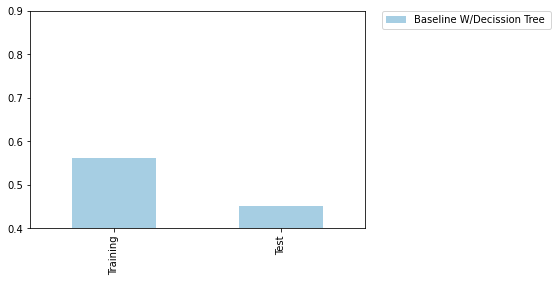

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.50      0.50      0.50        22
       plane       0.44      0.44      0.44        27
       train       0.41      0.41      0.41        22

    accuracy                           0.45        71
   macro avg       0.45      0.45      0.45        71
weighted avg       0.45      0.45      0.45        71

Accuracy: 45.07%

 Confusion Matrix:


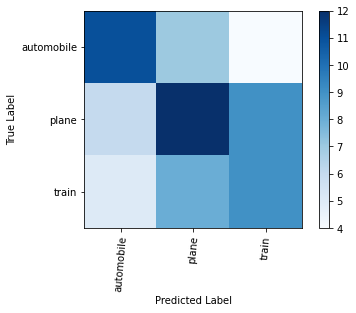

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "Baseline W/Decission Tree ", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Contrast Improvement

/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


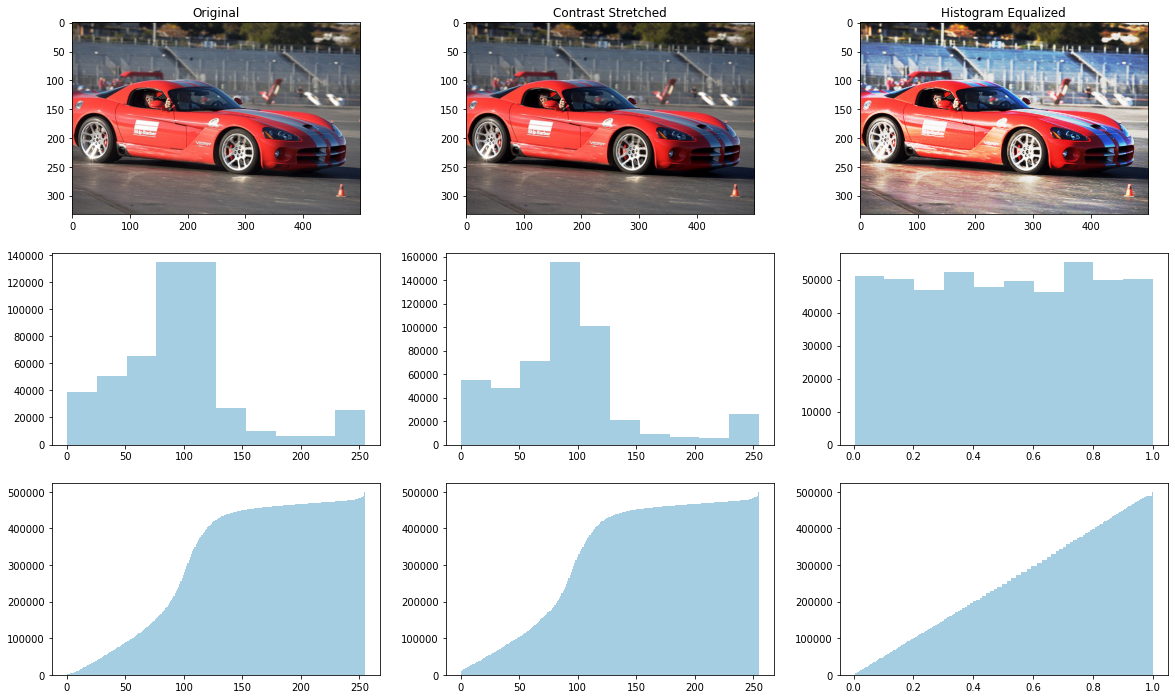

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mp_image

# Required magic to display matplotlib plots in notebooks
%matplotlib inline

# Load the image from the source file
image_file = "/content/drive/My Drive/Computer Vision/Individual Assignment/data/Training/automobile/000131.jpg"
image = mp_image.imread(image_file)

from skimage import exposure
import numpy as np

# Contrast stretching
p2 = np.percentile(image, 2)
p98 = np.percentile(image, 98)
image_ct = exposure.rescale_intensity(image, in_range=(p2, p98))

# Histogram Equalization
image_eq = exposure.equalize_hist(image)

# Show the images
fig = plt.figure(figsize=(20, 12))

# Subplot for original image
a=fig.add_subplot(3,3,1)
imgplot = plt.imshow(image)
a.set_title('Original')

# Subplot for contrast stretched image
a=fig.add_subplot(3,3,2)
imgplot = plt.imshow(image_ct)
a.set_title('Contrast Stretched')

# Subplot for equalized image
a=fig.add_subplot(3,3,3)
imgplot = plt.imshow(image_eq)
a.set_title('Histogram Equalized')

# Subplots for histograms
a=fig.add_subplot(3,3,4)
imgplot = plt.hist(image.ravel())

a=fig.add_subplot(3,3,5)
imgplot = plt.hist(image_ct.ravel())

a=fig.add_subplot(3,3,6)
imgplot = plt.hist(image_eq.ravel())

# Subplots for CDFs

a=fig.add_subplot(3,3,7)
imgplot = plt.hist(image.ravel(), bins=255, cumulative=True)

a=fig.add_subplot(3,3,8)
imgplot = plt.hist(image_ct.ravel(), bins=255, cumulative=True)

a=fig.add_subplot(3,3,9)
imgplot = plt.hist(image_eq.ravel(), bins=255, cumulative=True)

plt.show()

#### Contrast Stretching

Contrast stretching is using the whole range of values of pixels.

In [ ]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import exposure

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root, d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root, d, f)
                img = plt.imread(imgFile)

                # Resize the image
                img = resize(img, (128, 128), anti_aliasing=True)

                # Contrast stretching
                p2 = np.percentile(img, 2)
                p98 = np.percentile(img, 98)
                img = exposure.rescale_intensity(img, in_range=(p2, p98))

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id)
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print('Feature Shape:',features.shape)

Reading data from automobile
Reading data from plane
Reading data from train
234 features
234 labels
3 classes: ['automobile', 'plane', 'train']
Feature Shape: (234, 49152)


In [ ]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=0)

# Convert the train and test features to floats so they can be scaled
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(max_depth = 5, random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.5000 (+/- 0.17)
Accuracy Test: 0.5352 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

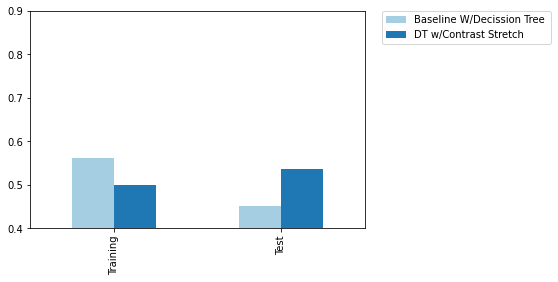

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.47      0.41      0.44        22
       plane       0.56      0.52      0.54        27
       train       0.56      0.68      0.61        22

    accuracy                           0.54        71
   macro avg       0.53      0.54      0.53        71
weighted avg       0.53      0.54      0.53        71

Accuracy: 53.52%

 Confusion Matrix:


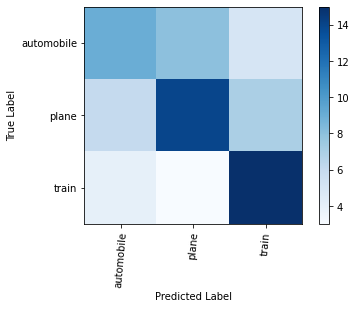

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "DT w/Contrast Stretch", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Histogram Equalization

In [ ]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import exposure

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root, d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root, d, f)
                img = plt.imread(imgFile)
                
                # Resize the image
                img = resize(img, (128, 128), anti_aliasing=True)

                # Histogram Equalization
                img = exposure.equalize_hist(img)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id)
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from automobile


/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


Reading data from plane
Reading data from train
234 features
234 labels
3 classes: ['automobile', 'plane', 'train']
Feature Shape: (234, 49152)
Labels Shape: (234,)


In [ ]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=0)

# Convert the train and test features to floats so they can be scaled
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(max_depth = 5, random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.6250 (+/- 0.11)
Accuracy Test: 0.6620 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

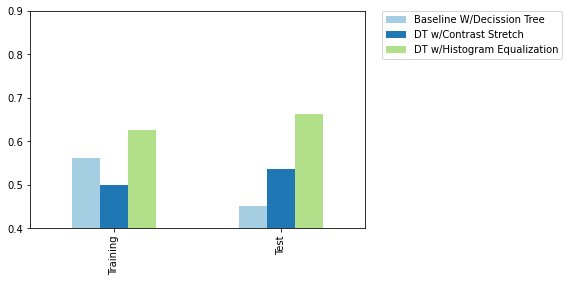

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.58      0.64      0.61        22
       plane       0.69      0.74      0.71        27
       train       0.72      0.59      0.65        22

    accuracy                           0.66        71
   macro avg       0.67      0.66      0.66        71
weighted avg       0.67      0.66      0.66        71

Accuracy: 66.20%

 Confusion Matrix:


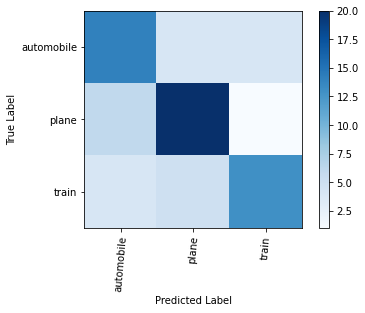

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "DT w/Histogram Equalization", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

From the result obtained above it seems pretty obvious that we should use histogram equalization and not contrast stretching on the images as it has given the best score yet. Histogram equalization makes the images less natural looking, but that is not the purpose of this t all, here we want to classify. The method is used to counteract contrast variance in images, and is therefor well equipped for a machine learning model.

### Image Filtering

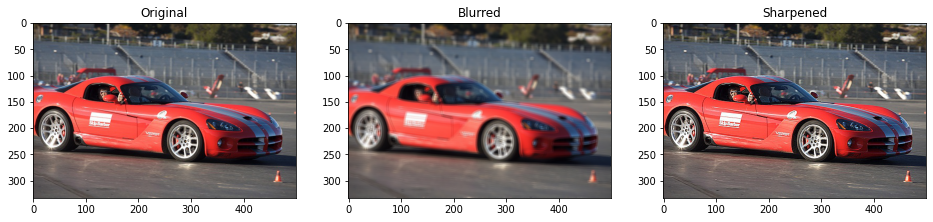

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

# Required magic to display matplotlib plots in notebooks
%matplotlib inline

# Load the image from the source file
image_file = "/content/drive/My Drive/Computer Vision/Individual Assignment/data/Training/automobile/000131.jpg"
image = Image.open(image_file)

blurred_image = image.filter(ImageFilter.BLUR)
sharpened_image = image.filter(ImageFilter.SHARPEN)

# Display it
fig = plt.figure(figsize=(16, 12))

# Plot original image
a=fig.add_subplot(1, 3, 1)
image_plot_1 = plt.imshow(image)
a.set_title("Original")

# Plot blurred image
a=fig.add_subplot(1, 3, 2)
image_plot_2 = plt.imshow(blurred_image)
a.set_title("Blurred")

# Plot sharpened image
a=fig.add_subplot(1, 3, 3)
image_plot_3 = plt.imshow(sharpened_image)
a.set_title("Sharpened")

plt.show()

#### Blurred

In [ ]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    import cv2

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root, d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root, d, f)
                img = plt.imread(imgFile)
                
                # Resize the image
                img = resize(img, (128, 128), anti_aliasing=True)
                
                # Using cv2.blur() method  
                img = cv2.GaussianBlur(img, (5,5), cv2.BORDER_DEFAULT)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id)
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from automobile
Reading data from plane
Reading data from train
234 features
234 labels
3 classes: ['automobile', 'plane', 'train']
Feature Shape: (234, 49152)
Labels Shape: (234,)


In [ ]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=0)

# Convert the train and test features to floats so they can be scaled
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(max_depth = 5, random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.6250 (+/- 0.14)
Accuracy Test: 0.5070 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

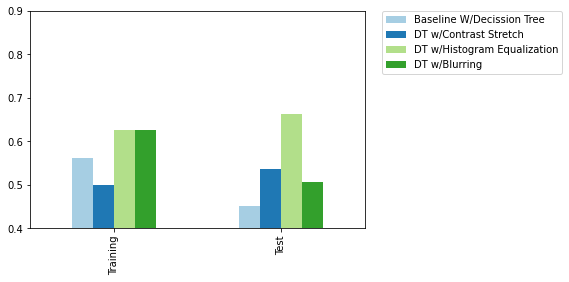

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.46      0.50      0.48        22
       plane       0.62      0.48      0.54        27
       train       0.46      0.55      0.50        22

    accuracy                           0.51        71
   macro avg       0.51      0.51      0.51        71
weighted avg       0.52      0.51      0.51        71

Accuracy: 50.70%

 Confusion Matrix:


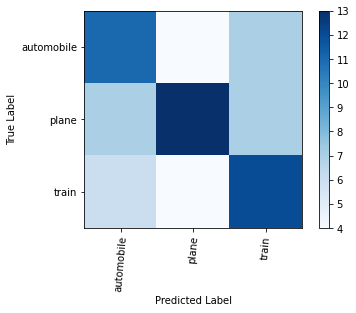

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "DT w/Blurring", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Blurring the image does not seem to be a good fit for this classification, so in any case the Histogram Equalization will be continued to be used.

#### Sharpened

In [ ]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import exposure
    import cv2

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root, d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root, d, f)
                img = plt.imread(imgFile)
                
                # Resize the image
                img = resize(img, (128, 128), anti_aliasing=True)

                # Using sharpening
                kernel = np.array([[-2,-2,-2], 
                                   [-2, 32,-2],
                                   [-2,-2,-2]])
                sharpened = cv2.filter2D(img, -1, kernel)
                
                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id)
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from automobile
Reading data from plane
Reading data from train
234 features
234 labels
3 classes: ['automobile', 'plane', 'train']
Feature Shape: (234, 49152)
Labels Shape: (234,)


Since the sharpening code we learned in class is a PIL library code, it does not work here, but I went in the code and found the kernel code used for that one, and applied it manually with a selfmade kernel.

In [ ]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=0)

# Convert the train and test features to floats so they can be scaled
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(max_depth = 5, random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.5625 (+/- 0.21)
Accuracy Test: 0.4507 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

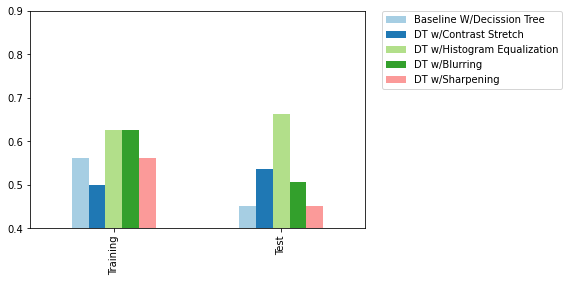

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.50      0.50      0.50        22
       plane       0.44      0.44      0.44        27
       train       0.41      0.41      0.41        22

    accuracy                           0.45        71
   macro avg       0.45      0.45      0.45        71
weighted avg       0.45      0.45      0.45        71

Accuracy: 45.07%

 Confusion Matrix:


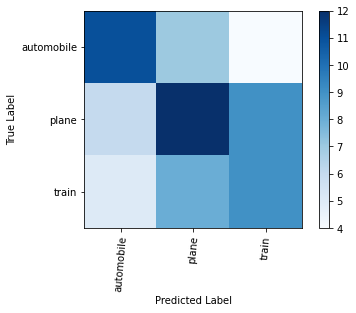

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "DT w/Sharpening", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Even with a good sharpening tool, it does not seem to help in this scenario, and this method is not looked at further.

#### Edge Detection: Sobel

The Sobel edge-detection algorithm convolts two filters across an image to find the horizontal and vertical vector gradients for each pixel, and then calculating the magnitude (length) of each vector gradient. 

In [ ]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    import cv2

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root, d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root, d, f)
                img = plt.imread(imgFile)
                
                # Resize the image
                img = resize(img, (128, 128), anti_aliasing=True)

                #sobel edge detection
                sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
                sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
                #print(sobelx.type)
                #magniture
                sobel=np.sqrt(np.multiply(sobelx,sobelx)+np.multiply(sobely,sobely))
                vis = np.concatenate((img, sobel), axis=0)
                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id)
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from automobile
Reading data from plane
Reading data from train
234 features
234 labels
3 classes: ['automobile', 'plane', 'train']
Feature Shape: (234, 49152)
Labels Shape: (234,)


In [ ]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=0)

# Convert the train and test features to floats so they can be scaled
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(max_depth = 5, random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.5625 (+/- 0.21)
Accuracy Test: 0.4507 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

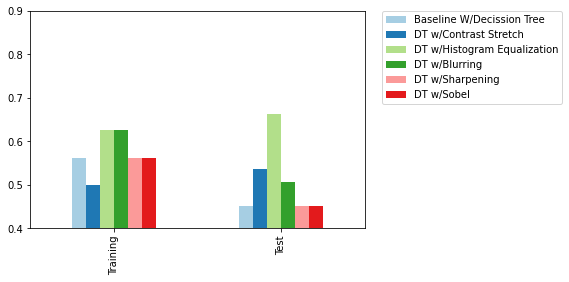

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.50      0.50      0.50        22
       plane       0.44      0.44      0.44        27
       train       0.41      0.41      0.41        22

    accuracy                           0.45        71
   macro avg       0.45      0.45      0.45        71
weighted avg       0.45      0.45      0.45        71

Accuracy: 45.07%

 Confusion Matrix:


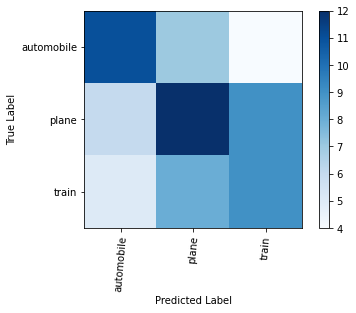

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "DT w/Sobel", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

From the result above, we can see that Sobel is a method not fit for this classification.

#### Edge Detection: Counting Edges

In [ ]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    import cv2

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = cv2.imread(imgFile)
                # grayscale
                imggray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
                # count corners
                corners = len(cv2.goodFeaturesToTrack(imggray,0,0.01,5))
                # use corners as only feature
                features.append(corners)                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id)
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features).reshape(-1, 1)
    
    return features, labels, classnames

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from automobile
Reading data from plane
Reading data from train
234 features
234 labels
3 classes: ['automobile', 'plane', 'train']
Feature Shape: (234, 1)
Labels Shape: (234,)


In [ ]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=0)

# Convert the train and test features to floats so they can be scaled
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(max_depth = 5, random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.6250 (+/- 0.13)
Accuracy Test: 0.5634 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

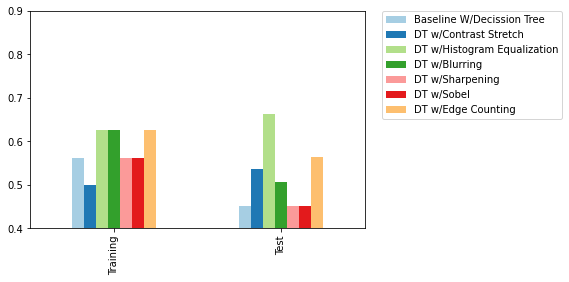

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.37      0.45      0.41        22
       plane       0.78      0.52      0.62        27
       train       0.62      0.73      0.67        22

    accuracy                           0.56        71
   macro avg       0.59      0.57      0.57        71
weighted avg       0.60      0.56      0.57        71

Accuracy: 56.34%

 Confusion Matrix:


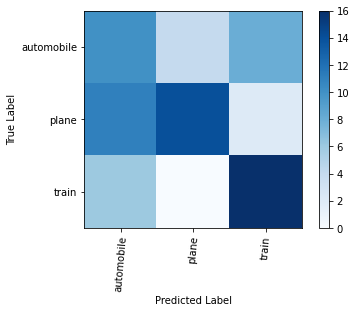

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "DT w/Edge Counting", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Clearly it does not help much just counting edges for this instance. There is after all edges all over in the picture, and not as easy to predict based on this as in the example of squares, circles and triangles seen in class.

### Thresholding

Below I will be printing different thresholding methods to see if there is any that sticks out to be used.

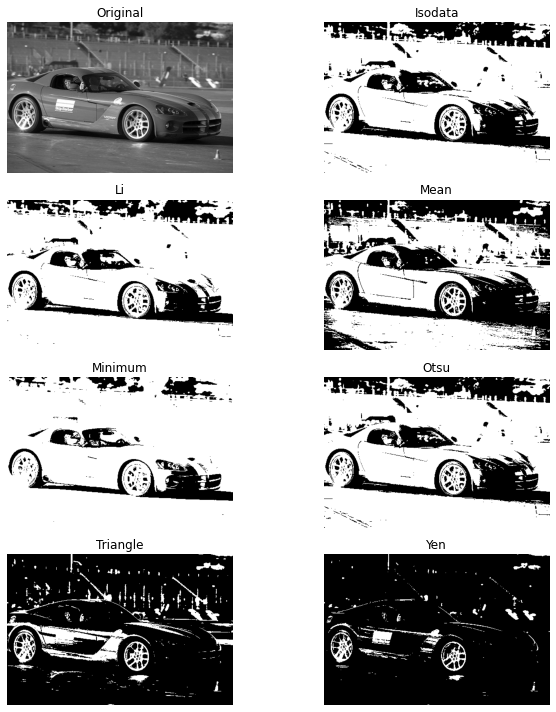

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage import io as sk_io, color as sk_col, morphology as sk_mm
from skimage.filters import threshold_mean
from skimage.filters import try_all_threshold

%matplotlib inline

# Load the image from the source file
image_file = "/content/drive/My Drive/Computer Vision/Individual Assignment/data/Training/automobile/000131.jpg"
image = sk_io.imread(image_file)

# Convert to grayscale so we only have one channel
bw_image = sk_col.rgb2gray(image)

fig, ax = try_all_threshold(bw_image, figsize=(10, 10), verbose=False)
plt.show()

Although it is only based on this one image, it would be interesting to see which one works the best for the model. I did try to run all of them, because it was very fast to change in the code. I did a mistake here though because I forgot to remove some pieces of code before I ran the model, which showed that "Triangle" and "Yen" works bets in watershed segmetnation, and when erosion and dilation is applied after to the image. But if you look at only thresholding by itself, Triangle performs the worst, which is interesting consider it did the best in this combination, which I will show after introducing erosion and dialtion by itself in "pipeline_1". I decided to leave only Yen and Triangle as those had the most interesting results, although otsu, isodata, minimum, mean and li had around the same result as Yen, at around .5 accuracy.

#### Yen Thresholding

In [ ]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import color as sk_col
    from skimage.filters import threshold_yen
    from skimage import morphology as sk_mm

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root, d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root, d, f)
                img = plt.imread(imgFile)
                
                # Resize the image
                img = resize(img, (128, 128), anti_aliasing=True)
                
                # Convert to grayscale so we only have one channel
                bw_img = sk_col.rgb2gray(img)
                img_yen = threshold_yen(bw_img)
                img = bw_img > img_yen

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id)
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from automobile
Reading data from plane
Reading data from train
234 features
234 labels
3 classes: ['automobile', 'plane', 'train']
Feature Shape: (234, 16384)
Labels Shape: (234,)


In [ ]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=0)

# Convert the train and test features to floats so they can be scaled
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(max_depth = 5, random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.5000 (+/- 0.19)
Accuracy Test: 0.5070 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

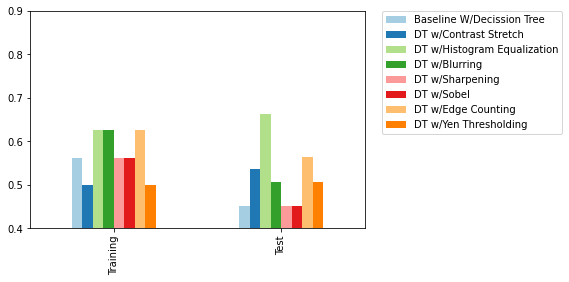

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.50      0.36      0.42        22
       plane       0.53      0.70      0.60        27
       train       0.47      0.41      0.44        22

    accuracy                           0.51        71
   macro avg       0.50      0.49      0.49        71
weighted avg       0.50      0.51      0.50        71

Accuracy: 50.70%

 Confusion Matrix:


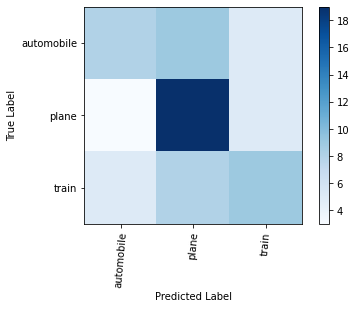

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "DT w/Yen Thresholding", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Triangle Thresholding

In [ ]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import color as sk_col
    from skimage.filters import threshold_triangle
    from skimage import morphology as sk_mm

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root, d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root, d, f)
                img = plt.imread(imgFile)
                
                # Resize the image
                img = resize(img, (128, 128), anti_aliasing=True)
                
                # Convert to grayscale so we only have one channel
                bw_img = sk_col.rgb2gray(img)
                img_triangle = threshold_triangle(bw_img)
                img = bw_img > img_triangle

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id)
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from automobile
Reading data from plane
Reading data from train
234 features
234 labels
3 classes: ['automobile', 'plane', 'train']
Feature Shape: (234, 16384)
Labels Shape: (234,)


In [ ]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=0)

# Convert the train and test features to floats so they can be scaled
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(max_depth = 5, random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.5000 (+/- 0.13)
Accuracy Test: 0.4085 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

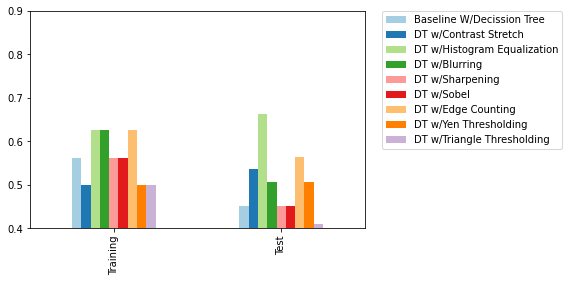

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.12      0.09      0.10        22
       plane       0.64      0.52      0.57        27
       train       0.41      0.59      0.48        22

    accuracy                           0.41        71
   macro avg       0.39      0.40      0.39        71
weighted avg       0.40      0.41      0.40        71

Accuracy: 40.85%

 Confusion Matrix:


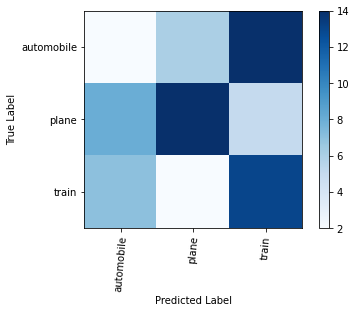

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "DT w/Triangle Thresholding", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Segmentation and Morphology

#### Erosion

In [ ]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import color as sk_col
    from skimage import morphology as sk_mm

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root, d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root, d, f)
                img = plt.imread(imgFile)
                
                # Resize the image
                img = resize(img, (128, 128), anti_aliasing=True)
                
                # Apply erosion
                img = sk_mm.erosion(img)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id)
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from automobile
Reading data from plane
Reading data from train
234 features
234 labels
3 classes: ['automobile', 'plane', 'train']
Feature Shape: (234, 49152)
Labels Shape: (234,)


In [ ]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=0)

# Convert the train and test features to floats so they can be scaled
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(max_depth = 5, random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.6250 (+/- 0.19)
Accuracy Test: 0.5493 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

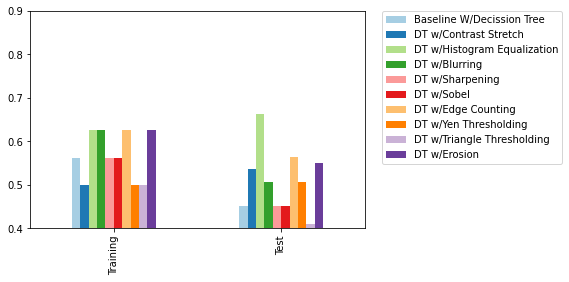

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.50      0.50      0.50        22
       plane       0.64      0.52      0.57        27
       train       0.52      0.64      0.57        22

    accuracy                           0.55        71
   macro avg       0.55      0.55      0.55        71
weighted avg       0.56      0.55      0.55        71

Accuracy: 54.93%

 Confusion Matrix:


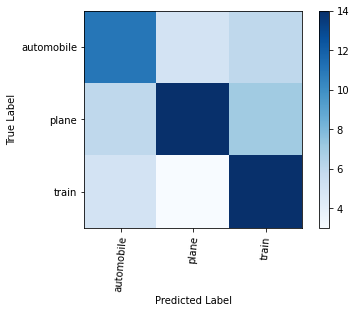

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "DT w/Erosion", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Dilation

In [ ]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import color as sk_col
    from skimage.filters import threshold_triangle
    from skimage import morphology as sk_mm

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root, d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root, d, f)
                img = plt.imread(imgFile)
                
                # Resize the image
                img = resize(img, (128, 128), anti_aliasing=True)
                
                # Apply Dilation
                img = sk_mm.dilation(img)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id)
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from automobile
Reading data from plane
Reading data from train
234 features
234 labels
3 classes: ['automobile', 'plane', 'train']
Feature Shape: (234, 49152)
Labels Shape: (234,)


In [ ]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=0)

# Convert the train and test features to floats so they can be scaled
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(max_depth = 5, random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.6250 (+/- 0.13)
Accuracy Test: 0.4085 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

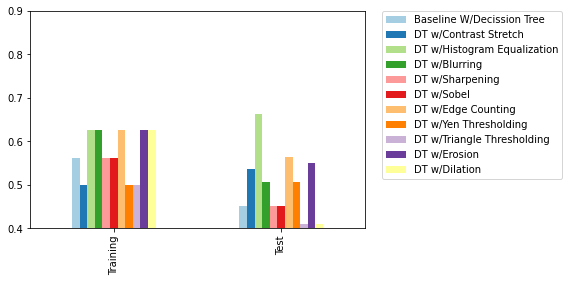

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.23      0.23      0.23        22
       plane       0.58      0.52      0.55        27
       train       0.40      0.45      0.43        22

    accuracy                           0.41        71
   macro avg       0.40      0.40      0.40        71
weighted avg       0.42      0.41      0.41        71

Accuracy: 40.85%

 Confusion Matrix:


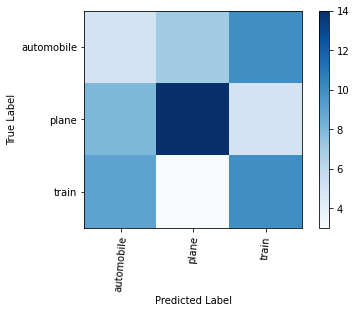

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "DT w/Dilation", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Closing: Dilation followed by Erosion


In [ ]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import color as sk_col
    from skimage.filters import threshold_triangle
    from skimage import morphology as sk_mm

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root, d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root, d, f)
                img = plt.imread(imgFile)
                
                # Resize the image
                img = resize(img, (128, 128), anti_aliasing=True)
                
                # Applying closing
                img = sk_mm.closing(img)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id)
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from automobile
Reading data from plane
Reading data from train
234 features
234 labels
3 classes: ['automobile', 'plane', 'train']
Feature Shape: (234, 49152)
Labels Shape: (234,)


In [ ]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=0)

# Convert the train and test features to floats so they can be scaled
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(max_depth = 5, random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.6250 (+/- 0.12)
Accuracy Test: 0.5070 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

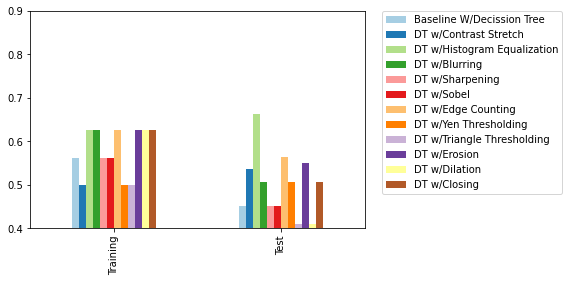

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.50      0.64      0.56        22
       plane       0.58      0.41      0.48        27
       train       0.46      0.50      0.48        22

    accuracy                           0.51        71
   macro avg       0.51      0.51      0.51        71
weighted avg       0.52      0.51      0.50        71

Accuracy: 50.70%

 Confusion Matrix:


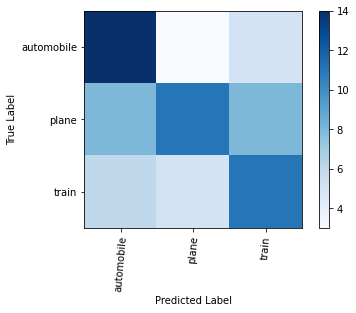

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "DT w/Closing", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Opening: Erosion followed by Dilation


In [ ]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import color as sk_col
    from skimage.filters import threshold_triangle
    from skimage import morphology as sk_mm

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root, d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root, d, f)
                img = plt.imread(imgFile)
                
                # Resize the image
                img = resize(img, (128, 128), anti_aliasing=True)
                
                # Applying closing
                img = sk_mm.opening(img)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id)
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from automobile
Reading data from plane
Reading data from train
234 features
234 labels
3 classes: ['automobile', 'plane', 'train']
Feature Shape: (234, 49152)
Labels Shape: (234,)


In [ ]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=0)

# Convert the train and test features to floats so they can be scaled
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(max_depth = 5, random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.5903 (+/- 0.18)
Accuracy Test: 0.4648 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

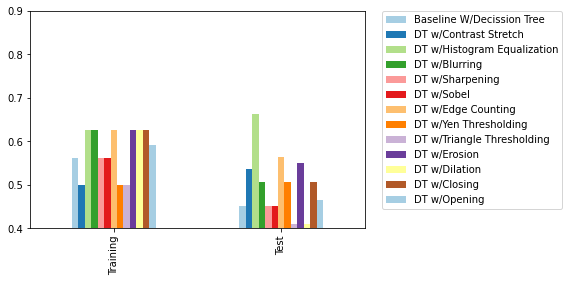

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.40      0.45      0.43        22
       plane       0.50      0.52      0.51        27
       train       0.50      0.41      0.45        22

    accuracy                           0.46        71
   macro avg       0.47      0.46      0.46        71
weighted avg       0.47      0.46      0.46        71

Accuracy: 46.48%

 Confusion Matrix:


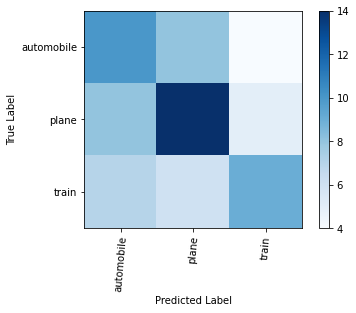

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "DT w/Opening", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

We can see that from all these four methods, closing performed the best.

### Pipeline 1

Here I am using Watershed Segmentation

In [ ]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import color as sk_col
    from skimage.filters import threshold_triangle
    from skimage import morphology as sk_mm

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root, d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root, d, f)
                img = plt.imread(imgFile)
                
                # Resize the image
                img = resize(img, (128, 128), anti_aliasing=True)
                
                # Convert to grayscale so we only have one channel
                bw_img = sk_col.rgb2gray(img)
                img_triangle = threshold_triangle(bw_img)
                thresh_img = bw_img > img_triangle

                # Convert the thresholded image to its inverse
                inverse_thresh = np.invert(thresh_img)

                # Use opening and dilation to find the background
                kernel = sk_mm.selem.square(3)
                opened_thresh = sk_mm.opening(inverse_thresh, kernel)
                img = sk_mm.dilation(opened_thresh, kernel)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id)
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from automobile
Reading data from plane
Reading data from train
234 features
234 labels
3 classes: ['automobile', 'plane', 'train']
Feature Shape: (234, 16384)
Labels Shape: (234,)


In [ ]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=0)

# Convert the train and test features to floats so they can be scaled
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(max_depth = 5, random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.5000 (+/- 0.16)
Accuracy Test: 0.6197 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

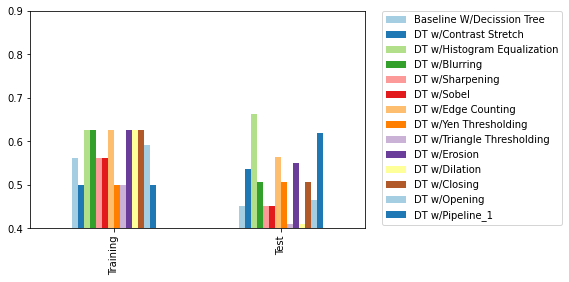

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.52      0.59      0.55        22
       plane       0.76      0.59      0.67        27
       train       0.60      0.68      0.64        22

    accuracy                           0.62        71
   macro avg       0.63      0.62      0.62        71
weighted avg       0.64      0.62      0.62        71

Accuracy: 61.97%

 Confusion Matrix:


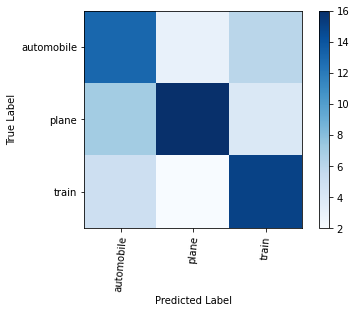

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "DT w/Pipeline_1", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Pipeline 2

Here I am using Histogram Equalization and Watershed Segmentation

In [ ]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import color as sk_col
    from skimage.filters import threshold_triangle
    from skimage import morphology as sk_mm, exposure

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root, d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root, d, f)
                img = plt.imread(imgFile)
                
                # Resize the image
                img = resize(img, (128, 128), anti_aliasing=True)
                
                # Histogram Equalization
                img = exposure.equalize_hist(img)

                # Convert to grayscale so we only have one channel
                bw_img = sk_col.rgb2gray(img)
                img_triangle = threshold_triangle(bw_img)
                thresh_img = bw_img > img_triangle

                # Convert the thresholded image to its inverse
                inverse_thresh = np.invert(thresh_img)

                # Use opening and dilation to find the background
                kernel = sk_mm.selem.square(3)
                opened_thresh = sk_mm.opening(inverse_thresh, kernel)
                img = sk_mm.dilation(opened_thresh, kernel)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id)
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from automobile


/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


Reading data from plane
Reading data from train
234 features
234 labels
3 classes: ['automobile', 'plane', 'train']
Feature Shape: (234, 16384)
Labels Shape: (234,)


In [ ]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=0)

# Convert the train and test features to floats so they can be scaled
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(max_depth = 5, random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.5000 (+/- 0.15)
Accuracy Test: 0.5070 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

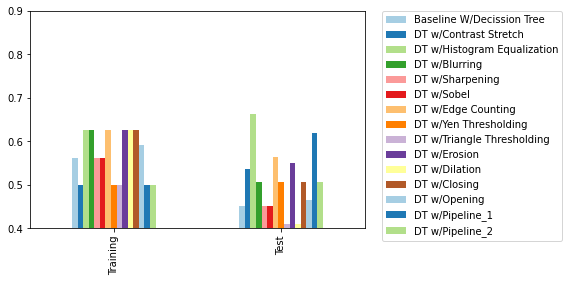

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.42      0.50      0.46        22
       plane       0.67      0.37      0.48        27
       train       0.50      0.68      0.58        22

    accuracy                           0.51        71
   macro avg       0.53      0.52      0.50        71
weighted avg       0.54      0.51      0.50        71

Accuracy: 50.70%

 Confusion Matrix:


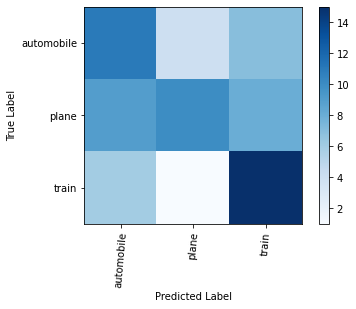

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "DT w/Pipeline_2", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Histogram of Oriented Gradients

As a last method to try, I found several sources on google about histogram of oriented gradients. 

HOG:
1.  Preprocess the image, including resizing and color normalization.

2. Compute the gradient vector of every pixel, as well as its magnitude and direction.

3. Divide the image into many 16x16 pixel cells. In each cell, the magnitude values of these 256 cells are binned and cumulatively added into buckets.

sources:

[GitHub Repository](https://lilianweng.github.io/lil-log/2017/10/29/object-recognition-for-dummies-part-1.html)

[StackOverflow](https://stackoverflow.com/questions/44955480/python-histogram-of-oriented-gradients)

In [ ]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import exposure
    import cv2
    from skimage.feature import hog

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root, d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root, d, f)
                img = plt.imread(imgFile)
                
                # Resize the image
                img = resize(img, (128, 128), anti_aliasing=True)

                # Convert to grayscale so we only have one channel
                img = sk_col.rgb2gray(img)

                # Applying Histogram of Oriented Gradients
                img = hog(img, orientations=8, pixels_per_cell=(16, 16),
                                    cells_per_block=(1, 1))

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id)
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from automobile
Reading data from plane
Reading data from train
234 features
234 labels
3 classes: ['automobile', 'plane', 'train']
Feature Shape: (234, 512)
Labels Shape: (234,)


In [ ]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=0)

# Convert the train and test features to floats so they can be scaled
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

In [ ]:
# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(max_depth = 5, random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.5000 (+/- 0.23)
Accuracy Test: 0.6620 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

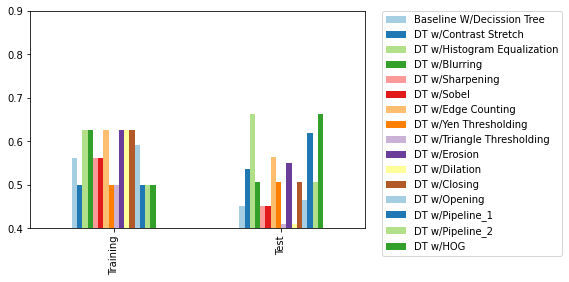

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.54      0.64      0.58        22
       plane       0.76      0.48      0.59        27
       train       0.71      0.91      0.80        22

    accuracy                           0.66        71
   macro avg       0.67      0.68      0.66        71
weighted avg       0.68      0.66      0.65        71

Accuracy: 66.20%

 Confusion Matrix:


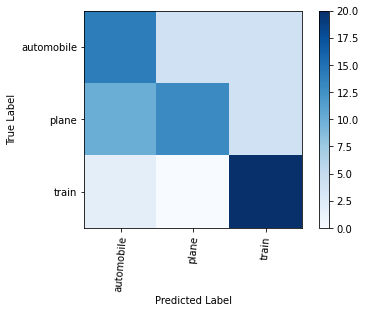

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "DT w/HOG", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Different Models with Histogram Equalization

From all the different methods tried, it is clear that Histogram Equalization and HOG had the most effect on the classification of the images. From here on now, I will only use these two pipelines to test different machine learning models. Starting off with the Histogram Equalization.

### Random Forest w/ Histogram Equalization

In [ ]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import exposure
    import cv2

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root, d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root, d, f)
                img = plt.imread(imgFile)
                
                # Resize the image
                img = resize(img, (128, 128), anti_aliasing=True)

                # Histogram Equalization
                img = exposure.equalize_hist(img)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id)
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from automobile


/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


Reading data from plane
Reading data from train
234 features
234 labels
3 classes: ['automobile', 'plane', 'train']
Feature Shape: (234, 49152)
Labels Shape: (234,)


In [ ]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=0)

# Convert the train and test features to floats so they can be scaled
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Grid search
parameters = {"min_samples_split": [3, 5, 7],"min_samples_leaf": [3, 5, 7],"n_estimators" : [400, 500, 700]}

rf = RandomForestClassifier(criterion= 'gini', n_estimators=500, max_features='auto',
                            oob_score = True, random_state=0, n_jobs = -1)

grid_rf = GridSearchCV(rf, parameters, cv=10, n_jobs=-1)
print("GridSearch started...")
grid_rf.fit(X_train_float, y_train)
print("Scoring...")
score = grid_rf.score(X_train_float, y_train)
print("Giving best parameters...")
best_params = grid_rf.best_params_
print('Score: {:.4f}'.format(score))
print('Best Params:\n{}'.format(best_params))

GridSearch started...
Scoring...
Giving best parameters...
Score: 0.9939
Best Params:
{'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 400}


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', RandomForestClassifier(min_samples_leaf = 3, min_samples_split = 3, 
                                                             n_estimators = 400, random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.7500 (+/- 0.10)
Accuracy Test: 0.7183 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

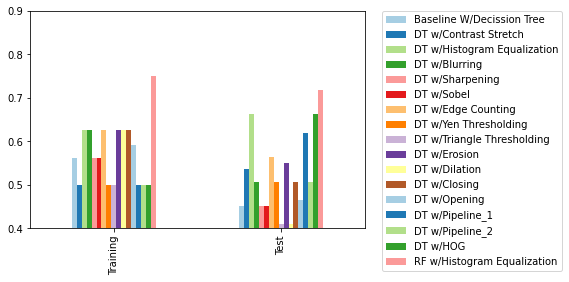

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.59      0.77      0.67        22
       plane       0.89      0.63      0.74        27
       train       0.74      0.77      0.76        22

    accuracy                           0.72        71
   macro avg       0.74      0.73      0.72        71
weighted avg       0.75      0.72      0.72        71

Accuracy: 71.83%

 Confusion Matrix:


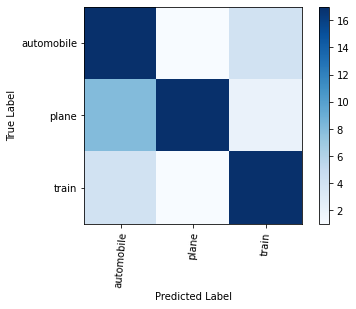

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "RF w/Histogram Equalization", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Although with a accuracy of 71.83 %, the model is not so good at detecting automobiles as planes. This can lead to missclassification.

### Support Vector Machine w/ Histogram Equalizer

Since I will be using the exact same processing steps as with the Random Forest Classifier, there is no need to put the code in here again. There is also no need to split in train and test sets as this also is already done.

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Grid search
parameters = { 'gamma': [0.001, 0.01, 0.1, 0.4, 0.5, 0.6, 0.7, 1], 'kernel': ['rbf'], 
              'C': [0.001, 0.01, 0.1, 1, 1.5, 2, 3, 10],}

svc = SVC(random_state=0)

grid_svc = GridSearchCV(svc, parameters, cv=10, n_jobs=-1)
print("GridSearch started...")
grid_svc.fit(X_train_float, y_train)
print("Scoring...")
score = grid_svc.score(X_train_float, y_train)
print("Giving best parameters...")
best_params = grid_svc.best_params_
print('Score: {:.4f}'.format(score))
print('Best Params:\n{}'.format(best_params))

GridSearch started...
Scoring...
Giving best parameters...
Score: 1.0000
Best Params:
{'C': 1.5, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
from sklearn.svm import SVC

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', SVC(C = 1.5, gamma = 0.001, kernel = 'rbf', random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.6250 (+/- 0.14)
Accuracy Test: 0.6338 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

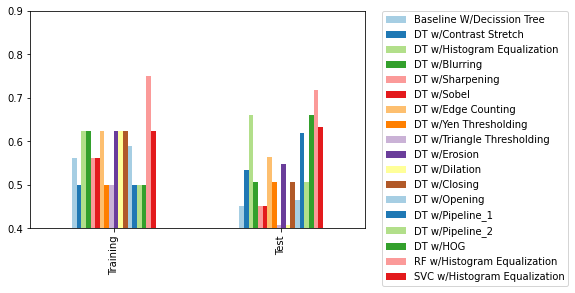

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.53      0.82      0.64        22
       plane       0.93      0.48      0.63        27
       train       0.61      0.64      0.62        22

    accuracy                           0.63        71
   macro avg       0.69      0.65      0.63        71
weighted avg       0.71      0.63      0.63        71

Accuracy: 63.38%

 Confusion Matrix:


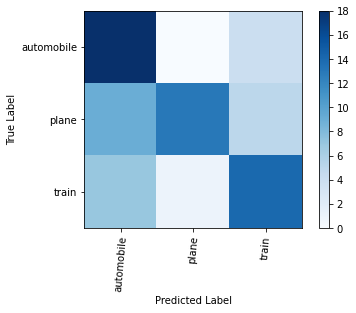

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "SVC w/Histogram Equalization", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

This model often classify non-plane images as planes even though they are not. an ideal matrix should be dark blue diagonally down.

### K-Neighbors Classifier w/ Histogram Equalizer

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Grid search
parameters = {'n_neighbors': [3,5,11,19], 'weights': ['uniform','distance'], 
              'metric': ['euclidean','manhattan']}

knn = KNeighborsClassifier()

grid_knn = GridSearchCV(knn, parameters, cv=10, verbose = 1, n_jobs=-1)
print("GridSearch started...")
grid_knn.fit(X_train_float, y_train)
print("Scoring...")
score = grid_knn.score(X_train_float, y_train)
print("Giving best parameters...")
best_params = grid_knn.best_params_
print('Score: {:.4f}'.format(score))
print('Best Params:\n{}'.format(best_params))

GridSearch started...
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.1min finished


Scoring...
Giving best parameters...
Score: 1.0000
Best Params:
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', KNeighborsClassifier(metric = 'manhattan', n_neighbors = 3, 
                                                           weights = 'distance')),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.6458 (+/- 0.14)
Accuracy Test: 0.5915 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

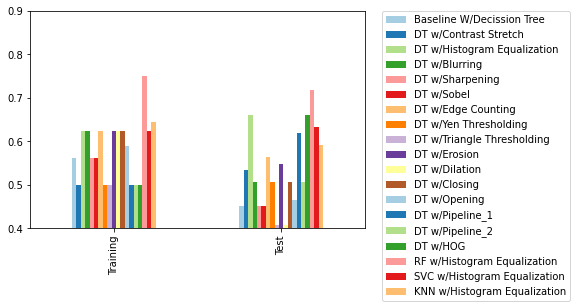

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.62      0.59      0.60        22
       plane       0.57      0.74      0.65        27
       train       0.60      0.41      0.49        22

    accuracy                           0.59        71
   macro avg       0.60      0.58      0.58        71
weighted avg       0.60      0.59      0.58        71

Accuracy: 59.15%

 Confusion Matrix:


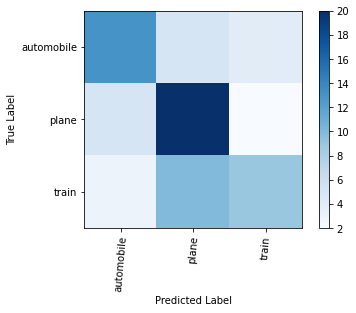

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "KNN w/Histogram Equalization", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

This model often classifies trains as planes, but other than that, if you ignore that it in general misclassifies, it is well distributed among the 3 labels.

### Gradient Tree Boosting w/ Histogram Equalizer

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Grid search
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.1, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.8],
    "n_estimators":[10]
    }

gbm = GradientBoostingClassifier(random_state=0)

grid_gbm = GridSearchCV(gbm, parameters, cv=10, verbose = 1, n_jobs=-1)
print("GridSearch started...")
grid_gbm.fit(X_train_float, y_train)
print("Scoring...")
score = grid_gbm.score(X_train_float, y_train)
print("Giving best parameters...")
best_params = grid_gbm.best_params_
print('Score: {:.4f}'.format(score))
print('Best Params:\n{}'.format(best_params))

GridSearch started...
Fitting 10 folds for each of 5184 candidates, totalling 51840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 366 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 1566 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2466 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3566 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4866 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 6366 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 8066 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 9966 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 12066 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 14366 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 16866 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 19566 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 22466 tasks  

Scoring...
Giving best parameters...
Score: 0.8650
Best Params:
{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.2090909090909091, 'n_estimators': 10, 'subsample': 0.5}


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', GradientBoostingClassifier(learning_rate = 0.1, loss = 'deviance', 
                                                                max_depth = 3, max_features = 'sqrt', 
                                                                 min_samples_leaf = 0.1, 
                                                                 min_samples_split = 0.2090909090909091, 
                                                                 n_estimators = 10, subsample = 0.5, random_state=0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.6458 (+/- 0.15)
Accuracy Test: 0.6338 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

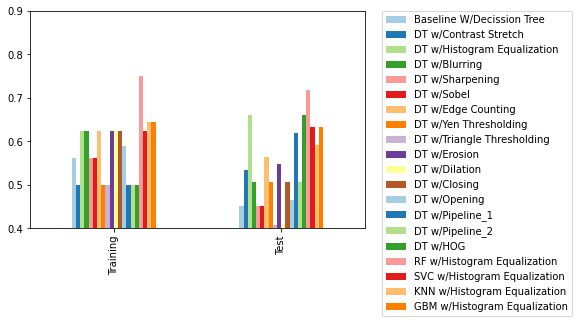

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.64      0.82      0.72        22
       plane       0.65      0.56      0.60        27
       train       0.60      0.55      0.57        22

    accuracy                           0.63        71
   macro avg       0.63      0.64      0.63        71
weighted avg       0.63      0.63      0.63        71

Accuracy: 63.38%

 Confusion Matrix:


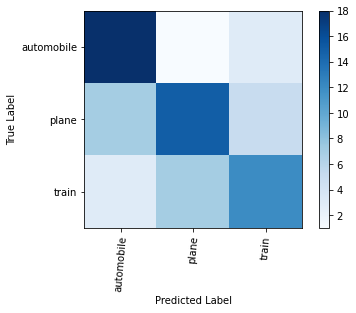

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "GBM w/Histogram Equalization", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

This model behaves similar to the one above, but is best at detecting automobiles.

### Naïve Bayes w/ Histogram Equalizer

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', GaussianNB()),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.7500 (+/- 0.16)
Accuracy Test: 0.6620 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

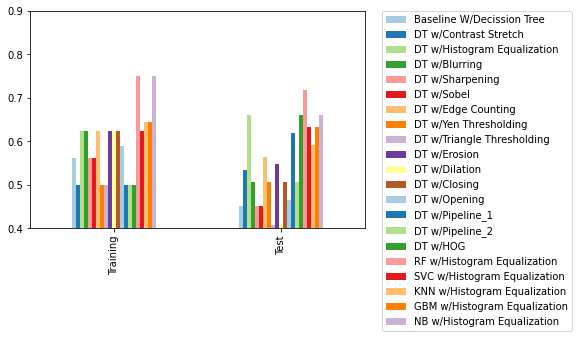

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.59      0.73      0.65        22
       plane       1.00      0.44      0.62        27
       train       0.59      0.86      0.70        22

    accuracy                           0.66        71
   macro avg       0.73      0.68      0.66        71
weighted avg       0.75      0.66      0.65        71

Accuracy: 66.20%

 Confusion Matrix:


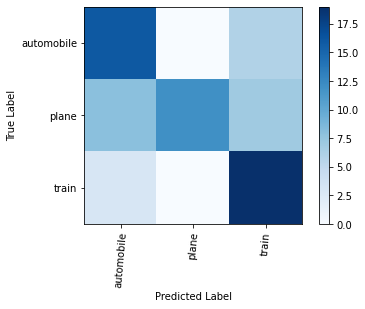

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "NB w/Histogram Equalization", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Although the score is fairly high compared to the other models I have been able to create, it does missclassify a lot .

## Different Models with Histogram of Oriented Gradients

From all the different methods tried, it is clear that Histogram Equalization and HOG had the most effect on the classification of the images. As mentioned, I will only use these two pipelines to test different machine learning models, and since I already did Histogram Equalization, HOG is shown below.

### Random Forest w/ HOG

In [ ]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    import cv2
    from skimage.feature import hog
    from skimage import color as sk_col

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root, d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root, d, f)
                img = plt.imread(imgFile)
                
                # Resize the image
                img = resize(img, (128, 128), anti_aliasing=True)

                # Convert to grayscale so we only have one channel
                img = sk_col.rgb2gray(img)

                # Applying Histogram of Oriented Gradients
                img = hog(img, orientations=8, pixels_per_cell=(16, 16),
                                    cells_per_block=(1, 1))

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id)
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from automobile
Reading data from plane
Reading data from train
234 features
234 labels
3 classes: ['automobile', 'plane', 'train']
Feature Shape: (234, 512)
Labels Shape: (234,)


In [ ]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=0)

# Convert the train and test features to floats so they can be scaled
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', RandomForestClassifier(min_samples_leaf = 3, min_samples_split = 3, 
                                                             n_estimators = 400, random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.7778 (+/- 0.10)
Accuracy Test: 0.8169 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

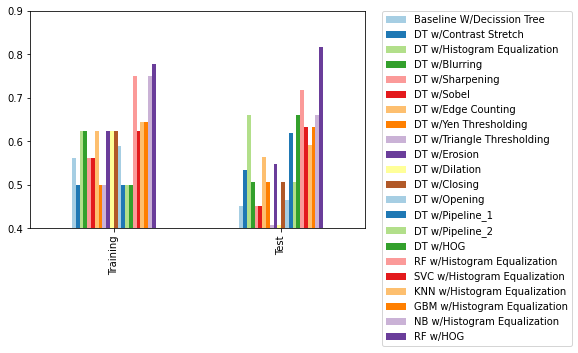

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.74      0.77      0.76        22
       plane       0.88      0.78      0.82        27
       train       0.83      0.91      0.87        22

    accuracy                           0.82        71
   macro avg       0.82      0.82      0.82        71
weighted avg       0.82      0.82      0.82        71

Accuracy: 81.69%

 Confusion Matrix:


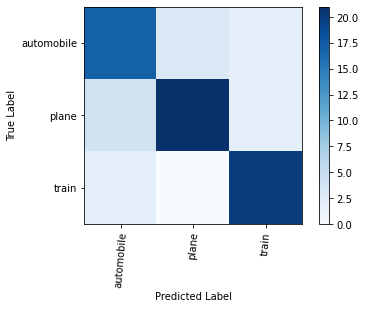

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "RF w/HOG", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

This model has a high accuracy of 81.69 %, and very much equally misclassify the different labels. This is a good model for further prediction.

### Support Vector Machine w/ HOG

Since I will be using the exact same processing steps as with the Random Forest Classifier, there is no need to put the code in here again. There is also no need to split in train and test sets as this also is already done.

In [ ]:
from sklearn.svm import SVC

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', SVC(C = 1.5, gamma = 0.001, kernel = 'rbf', random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.5278 (+/- 0.21)
Accuracy Test: 0.5493 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

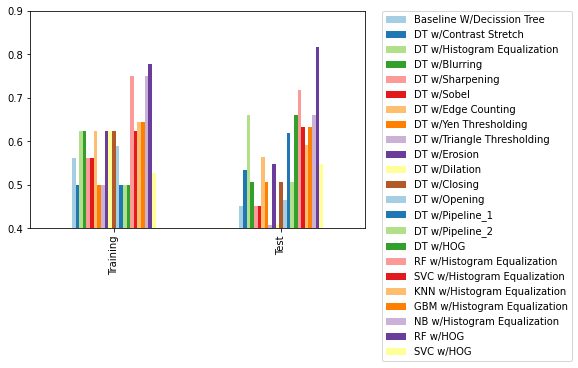

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.45      0.86      0.59        22
       plane       0.00      0.00      0.00        27
       train       0.69      0.91      0.78        22

    accuracy                           0.55        71
   macro avg       0.38      0.59      0.46        71
weighted avg       0.35      0.55      0.43        71

Accuracy: 54.93%

 Confusion Matrix:


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


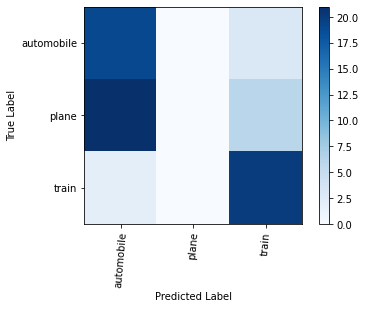

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "SVC w/HOG", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

This model has an accuracy score of 54.93 %, but can in no way classify if it is a plane or not with a 0.00 precision.

### K-Neighbors Classifier w/ HOG

In [ ]:
# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', KNeighborsClassifier(metric = 'manhattan', n_neighbors = 3, 
                                                           weights = 'distance')),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.7500 (+/- 0.15)
Accuracy Test: 0.7183 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

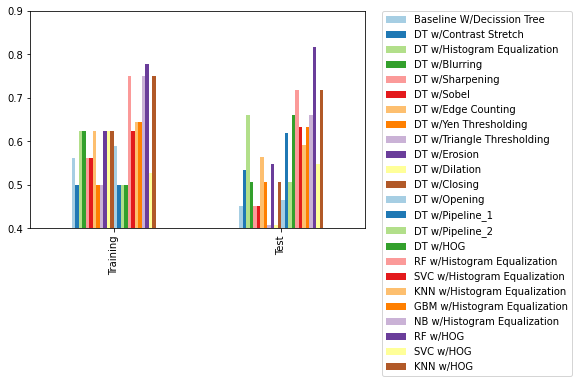

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.73      0.50      0.59        22
       plane       0.82      0.67      0.73        27
       train       0.65      1.00      0.79        22

    accuracy                           0.72        71
   macro avg       0.73      0.72      0.71        71
weighted avg       0.74      0.72      0.71        71

Accuracy: 71.83%

 Confusion Matrix:


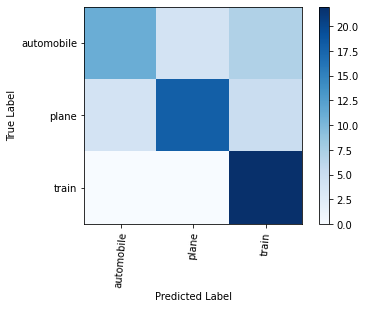

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "KNN w/HOG", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

This model has a high accuracy, but often misclassify the two other labels as trains, therefore a low precision.

### Gradient Tree Boosting w/ HOG

In [ ]:
# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', GradientBoostingClassifier(learning_rate = 0.1, loss = 'deviance', 
                                                                max_depth = 3, max_features = 'sqrt', 
                                                                 min_samples_leaf = 0.1, 
                                                                 min_samples_split = 0.2090909090909091, 
                                                                 n_estimators = 10, subsample = 0.5, random_state=0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.7500 (+/- 0.15)
Accuracy Test: 0.5352 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

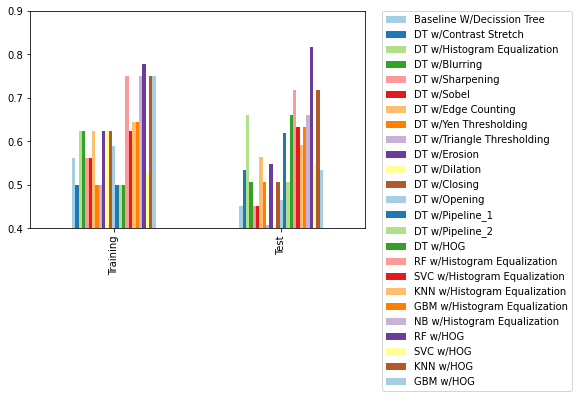

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.39      0.50      0.44        22
       plane       0.67      0.44      0.53        27
       train       0.60      0.68      0.64        22

    accuracy                           0.54        71
   macro avg       0.55      0.54      0.54        71
weighted avg       0.56      0.54      0.54        71

Accuracy: 53.52%

 Confusion Matrix:


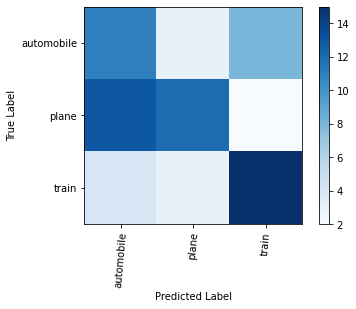

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "GBM w/HOG", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

This model does not know what an automobile is, and is in general not a good model.

### Naïve Bayes w/ HOG

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', GaussianNB()),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.7639 (+/- 0.17)
Accuracy Test: 0.7746 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

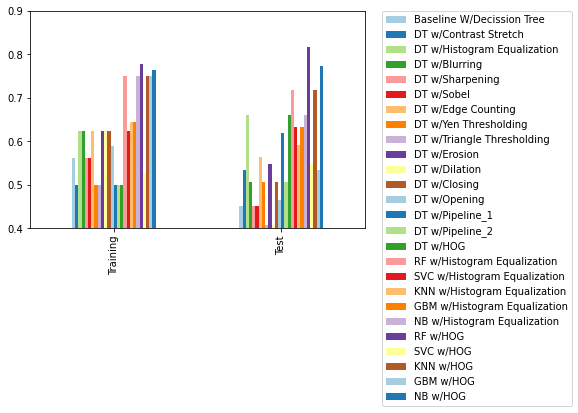

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.64      0.82      0.72        22
       plane       0.86      0.67      0.75        27
       train       0.86      0.86      0.86        22

    accuracy                           0.77        71
   macro avg       0.79      0.78      0.78        71
weighted avg       0.79      0.77      0.78        71

Accuracy: 77.46%

 Confusion Matrix:


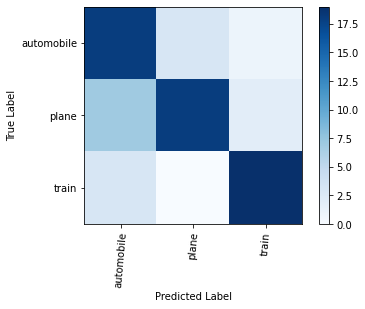

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "NB w/HOG", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

This model performs well on all labels, with an accuracy of 77.46 %. Although misclassifies a plane as a automobile sometimes more than the others are missclassified.

## Conclusion and Final Model

As seen from the comparison plot, Random Forest Classifier together with the Histogram of Oriented Gradient performed the best, and will therefore be the final model. You can find the model below, and this one will be saved and used on the unseen images.

In [ ]:
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

234 features
234 labels
3 classes: ['automobile', 'plane', 'train']
Feature Shape: (234, 512)
Labels Shape: (234,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', RandomForestClassifier(min_samples_leaf = 3, min_samples_split = 3, 
                                                             n_estimators = 400, random_state = 0)),
                        ])

# Using the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, y_train)
cv_scores = cross_val_score(clf, X_train_float, y_train, scoring = "accuracy", cv = 20)
print('classifier trained!')
print('Evaluating model...')
predicted = accuracy_score(y_test, clf.predict(X_test_float))
print('classifier evaluated!')

Training model...
classifier trained!
Evaluating model...
classifier evaluated!


Accuracy Train: 0.7778 (+/- 0.10)
Accuracy Test: 0.8169 (+/- 0.00)


<Figure size 576x720 with 0 Axes>

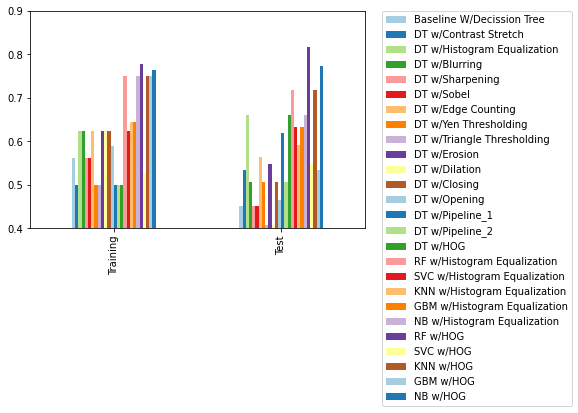

Classifier Metrics:
              precision    recall  f1-score   support

  automobile       0.74      0.77      0.76        22
       plane       0.88      0.78      0.82        27
       train       0.83      0.91      0.87        22

    accuracy                           0.82        71
   macro avg       0.82      0.82      0.82        71
weighted avg       0.82      0.82      0.82        71

Accuracy: 81.69%

 Confusion Matrix:


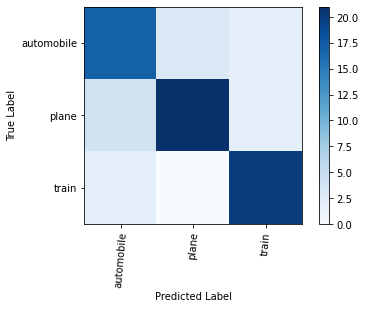

In [ ]:
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
plot_compare(result, "RF w/HOG", np.median(cv_scores), np.median(predicted))

print('Classifier Metrics:')
predictions = clf.predict(X_test_float)
print(metrics.classification_report(y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Save the Model

For this part where I save the model to use it on the unseen images, the processing of HOG made it hard, but not impossible. I changed the code provided in one of the notebooks by our professor Hind, and uploaded the images seperately again after making the prediction, showing the images again without the pre-processing that ruined the scaling, all this can be seen in the code.

In [ ]:
# Save the trained model
import sys
import os
import pickle

print ("Exporting the model")
file_stream = open('VOC_classifier.pkl', 'wb')
pickle.dump(clf, file_stream)
file_stream.close()

Exporting the model


In [13]:
# Helper function to resize image
def resize_image(src_img, size=(128,128), bg_color="white"): 
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))
  
    # return the resized image
    return new_image

# Function to predict the class of an image
def predict_image(classifier, image_array):
    import numpy as np
    
    # These are the classes our model can predict
    classnames = ['automobile', 'train', 'plane']
    
    # Predict the class of each input image
    predictions = classifier.predict(image_array)
    
    predicted_classes = []
    for prediction in predictions:
        # And append the corresponding class name to the results
        predicted_classes.append(classnames[int(prediction)])
    # Return the predictions
    return predicted_classes

print("Functions created - ready to use model for inference.")

Functions created - ready to use model for inference.


### Testing on unseen images

Importing the model


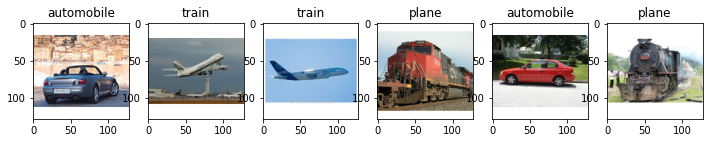

In [14]:
import os
import pickle
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from skimage.feature import hog
from skimage import color as sk_col

%matplotlib inline

# Load the model
print("Importing the model")
file_stream = open('VOC_classifier.pkl', 'rb')
clf = pickle.load(file_stream)
file_stream.close()

#get the list of test image files
test_folder = "/content/drive/My Drive/Computer Vision/Individual Assignment/data/Testing"
test_image_files = os.listdir(test_folder)

# Empty array on which to store the images
image_arrays = []

size = (128,128)
background_color = "white"

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_folder, test_image_files[file_idx]))

    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))

    # Convert to grayscale so we only have one channel
    img = sk_col.rgb2gray(resized_img)

    # Applying Histogram of Oriented Gradients
    img = hog(img, orientations=8, pixels_per_cell=(16, 16),
              cells_per_block=(1, 1))
    
    img_shape = np.array(img).shape
                      
    # Add the image to the array of images
    image_arrays.append(img.ravel())

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(clf, np.array(image_arrays))

image_arrays = []

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_folder, test_image_files[file_idx]))
    
    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))
    
    img_shape = np.array(resized_img).shape
                      
    # Add the image to the array of images
    image_arrays.append(resized_img.ravel())

# plot each image with its corresponding prediction
for idx in range(len(predictions)):
    a=fig.add_subplot(1,len(predictions),idx+1)
    img = image_arrays[idx].reshape(img_shape)
    imgplot = plt.imshow(img)
    a.set_title(predictions[idx])

As a final remark, you can see that the automobiles has been correctly labeled, while train and planes are mixed up. If there was more sample images it would have been possible to create a more accurate model, but here there was only a small number of images to train on.